In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import torch
import os
from pathlib import Path
import glob
import torch.nn as nn
from itertools import chain
import torch.optim as optim
import time
from progressbar import ETA, Bar, Percentage, ProgressBar
import simpleaudio as sa
# from model_Adp import *
from model_Adp_custom import *
import scipy.io as sio
from torchvision.io import read_image
import torchvision.transforms as transforms
from torchvision.transforms.functional import pad
from torch.utils.data import Dataset
import torchvision.utils as vutils
from torchvision.transforms import *
import torchvision
from collections import defaultdict
from IPython.display import display, clear_output
import torchaudio
from torchvision.transforms.functional import pad
from matplotlib.lines import Line2D

import joblib

import librosa
from tqdm import tqdm

from utils import audio_tools as audio
from utils.hparams import *

In [2]:
SR = hparams['sample_rate']
num_mels = hparams['num_mels']
IMAGE_SIZE = 512 # Generate melspectrogram image in 128 x 128

In [3]:
ngpu = 2
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


In [4]:
# # Read MNIST meta file and move folders to respective male and female folders
# import json
# import shutil
  
# # reading the data from the file
# with open('data/AudioMNIST/audioMNIST_meta.txt') as f:
#     data = f.read()
    
# data = json.loads(data)

# for key, value in data.items():
#     if value['gender'] == "male":
#         for file in glob.glob("./data/AudioMNIST/"+key+"/*"):
#             shutil.move(file, "./data/AudioMNIST/male/"+Path(file).stem+".wav")
#     elif value['gender'] == "female":
#         for file in glob.glob("./data/AudioMNIST/"+key+"/*"):
#             shutil.move(file, "./data/AudioMNIST/female/"+Path(file).stem+".wav")

In [5]:
# path_test = "data/wavfiles16kHz/TEST"
# path_train = "data/wavfiles16kHz/TRAIN"

# path_A = "data/AudioMNIST/male"
# path_B = "data/AudioMNIST/female"

path_A = "../../../scratch/sram/CMU/A"
path_B = "../../../scratch/sram/CMU/B"

n = 10000

files_A = glob.glob(path_A+"/*.wav")[:n]
files_B = glob.glob(path_B+"/*.wav")[:n]

In [6]:
if n > max(len(files_A), len(files_B)):
    n = max(len(files_A), len(files_B))
    
print("n: ",str(n))

n:  593


In [7]:
# PREPROCESS
# calculate means/standard diviation for normalization

def load_audio(path):
    y, sr = librosa.core.load(path, sr = SR)

    # sfft -> mel conversion
    db_mel = audio.melspectrogram(y)

    # means/standard diviation for each freq bin
    m_db_mel = np.mean(db_mel, axis=1)
    std_db_mel = np.std(db_mel, axis=1)
    return m_db_mel, std_db_mel

In [8]:
def as_np(data):
    return data.cpu().data.numpy()

In [9]:
# waveform, sample_rate = torchaudio.load(files_A[1])

# class AudioNormalize(object):
#     def __init__(self, x):
#         self.x = x

#     "Normalizes a single `AudioTensor`."
#     def encodes(self): return (self.x-self.x.mean()) / self.x.std()

# print(waveform.mean())
# print(waveform.var())

# def extract_logmel(y, sr, size=3):
#     """
#     extract log mel spectrogram feature
#     :param y: the input signal (audio time series)
#     :param sr: sample rate of 'y'
#     :param size: the length (seconds) of random crop from original audio, default as 3 seconds
#     :return: log-mel spectrogram feature
#     """
#     # normalization
#     y = y.astype(np.float32)
#     normalization_factor = 1 / np.max(np.abs(y))
#     y = y * normalization_factor

#     # extract log mel spectrogram
#     melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024, n_mels=128)
#     logmelspec = librosa.power_to_db(melspectrogram)

#     return logmelspec 

# ps_db = extract_logmel(as_np(waveform).squeeze(), sample_rate)

# print(ps_db.mean())
# print(ps_db.var())

# fig, ax = plt.subplots(figsize=(5,10))
# plt.imshow(ps_db, origin="lower", cmap=plt.get_cmap("magma"))

In [10]:
# def padding(array, xx, yy):
#     """
#     :param array: numpy array
#     :param xx: desired height
#     :param yy: desirex width
#     :return: padded array
#     """

#     h = array.shape[0]
#     w = array.shape[1]

#     a = (xx - h) // 2
#     aa = xx - a - h

#     b = (yy - w) // 2
#     bb = yy - b - w

#     return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [11]:
# # sample_rate, samples = wavfile.read(test_files[3])
# # frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

# # y, sr = librosa.load(files_A[1])
# ps = librosa.feature.melspectrogram(y=y, sr=sr)
# ps_db= librosa.power_to_db(ps, ref=np.max)

# # ps_db = padding(ps_db, 256, 256)

# # librosa.display.specshow(ps_db, x_axis='s', y_axis='log')
# fig, ax = plt.subplots(figsize=(5,10))
# plt.imshow(ps_db, origin="lower", cmap=plt.get_cmap("magma"))

In [12]:
# Image to npy array
# spect_dir_A = "./data/spectrograms/A/" 
# spect_dir_B = "./data/spectrograms/B/" 

spect_dir_A = "../../../scratch/sram/CMU/A_spect"
spect_dir_B = "../../../scratch/sram/CMU/B_spect"

In [13]:
# scaling - based on
# Donahue, C., McAuley, J., & Puckette, M. (2018). Synthesizing Audio with Generative Adversarial Networks.
# Retrieved from http://arxiv.org/abs/1802.04208
def normalize(s, mel_means, mel_stds):
    assert s.shape[0] == mel_means.shape[0]
    norm_Y = (s - mel_means[:,None]) / (3.0 * mel_stds[:,None])
    return np.clip(norm_Y, -1.0, 1.0)

def denormalize(norm_s):
    assert norm_s.shape[0] == mel_means.shape[0]
    Y = (norm_s * (3.0 * mel_stds)) + mel_means
    return Y

def load_melspecs(path, mel_means, mel_stds):
    filename = os.path.basename(path)

    y, sr = librosa.core.load(path, sr = SR)

    db_mel = audio.melspectrogram(y)
    
    assert  db_mel.shape[0] == num_mels

    dummy = np.ones((num_mels, IMAGE_SIZE)) * hparams['min_level_db']
    db_mel = np.hstack((db_mel, dummy))
    db_mel = db_mel[:, :IMAGE_SIZE]

    norm_mel = normalize(db_mel, mel_means, mel_stds)

    return norm_mel

In [14]:
def save_as_np(files, savepath):
    # parallel loading
    print("parallel loading audio... ")
    results = joblib.Parallel(n_jobs=-1)(
        joblib.delayed(load_audio)(path) for path in files)

    means = [mean for mean, _ in results if mean is not None]
    stds = [std for _, std in results if std is not None]

    # calcurate overall means/standard diviation
    means = np.array(means)
    stds = np.array(stds)

    mel_means = np.mean(means, axis=0)
    mel_stds = np.mean(stds, axis=0)
    
    print("generate normalized spectrogram images... ")
    # for path in files:
    #     load_melspecs(path, mel_means, mel_stds)
    
    results = joblib.Parallel(n_jobs=-1)(
        joblib.delayed(load_melspecs)(path, mel_means, mel_stds) for path in files)
    
    for i, result in zip(tqdm(range(n)), results):
        np.save(savepath+Path(files[i]).stem+".npy", result)

In [15]:
# save_as_np(files_A, spect_dir_A)
# save_as_np(files_B, spect_dir_B)

In [16]:
class TIMITDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.img_path = glob.glob(self.img_dir+"*.npy")

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        img_path = self.img_path[idx]
        image = np.load(img_path)
        # image = padding(image, 128, 128)
        if self.transform:
            image = self.transform(image)  
            
        image = image.type(torch.FloatTensor)
    
        return image

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
    
# dataset = torchvision.datasets.ImageFolder(spect_dir, transform)
data_A = TIMITDataset(spect_dir_A, transform=transform)
data_B = TIMITDataset(spect_dir_B, transform=transform)

print(data_A.__len__())
print(data_B.__len__())

593
539


In [17]:
img = 10

print(data_A.__getitem__(img).mean())
print(data_A.__getitem__(img).var())
print(data_A.__getitem__(img).shape)

tensor(-0.2909)
tensor(0.2826)
torch.Size([1, 256, 512])


In [18]:
# def image_grid(d, idxs):
#     images = [d[idx][0] for idx in idxs]
#     grid = torchvision.utils.make_grid(images)
#     return grid.numpy().transpose(1, 2, 0) / 2 + 0.5

# plt.figure(figsize=(10, 10))
# plt.imshow(image_grid(dataset, range(48)))
# plt.title('Speech signals')
# plt.axis('off')
# plt.tight_layout()

In [19]:
# size = int(n/4)
# print(size)

# data_A, data_B, test_A, test_B = torch.utils.data.random_split(dataset, [size, size, size, size])

In [20]:
iter(data_A)

In [21]:
# Create the dataloader
batch_size = 8
num_workers = 4

data_A = torch.utils.data.DataLoader(data_A, 
                                     batch_size=batch_size, 
                                     shuffle=True, 
                                     num_workers=num_workers,
                                     drop_last=True)

data_B = torch.utils.data.DataLoader(data_B, 
                                     batch_size=batch_size, 
                                     shuffle=True, 
                                     num_workers=num_workers,
                                     drop_last=True)

# test_A = torch.utils.data.DataLoader(test_A, 
#                                      batch_size=batch_size, 
#                                      shuffle=True, 
#                                      num_workers=num_workers)

# test_B = torch.utils.data.DataLoader(test_B, 
#                                      batch_size=batch_size, 
#                                      shuffle=True, 
#                                      num_workers=num_workers)

torch.Size([8, 1, 256, 512])


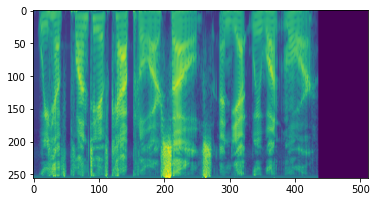

In [22]:
# Display image.
train_features = next(iter(data_A))
print(train_features.shape)
img = train_features[0].squeeze()
plt.imshow(img)
plt.savefig( "results/misc/one.jpg", bbox_inches='tight')
plt.show()

tensor([[-0.6300, -0.6300, -0.5812,  ..., -1.0000, -1.0000, -1.0000],
        [-0.6995, -0.6995, -0.6011,  ..., -1.0000, -1.0000, -1.0000],
        [-0.6713, -0.6713, -0.6446,  ..., -1.0000, -1.0000, -1.0000],
        ...,
        [-0.1642, -0.1642, -0.1642,  ..., -1.0000, -1.0000, -1.0000],
        [-0.1156, -0.1156, -0.1156,  ..., -1.0000, -1.0000, -1.0000],
        [-0.0899, -0.0899, -0.0899,  ..., -1.0000, -1.0000, -1.0000]])


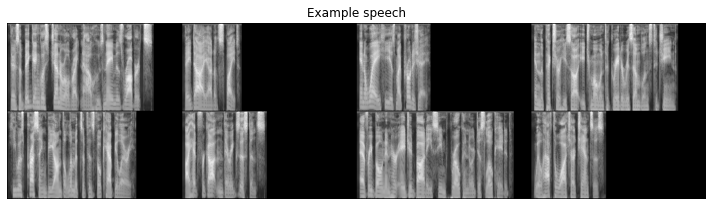

In [23]:
batch_tensor = next(iter(data_A))
print(batch_tensor[0][0])
grid_img = torchvision.utils.make_grid(batch_tensor, nrow=4, normalize=True)

plt.figure(figsize=(10, 10))
plt.title('Example speech')
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0), origin="lower", cmap=plt.get_cmap("magma"))
plt.tight_layout()
plt.savefig( "results/misc/example.jpg", dpi = 300, bbox_inches='tight')

In [24]:
# data_style_A, data_style_B, test_style_A, test_style_B = np.array_split(glob.glob(spect_dir+"*.npy"), 4)
# data_style_A.shape

In [25]:
# def read_spect_matrix(filenames):
#     images = []
#     for fn in filenames:
#         if fn[-3:] == 'mat':
#             image = scipy.io.loadmat(fn)
#             # pdb.set_trace()
#             image = image[fn[-12:-4]] #12 for val \, 14 for train
#             # make it 3x256x256
#             image = image.transpose(2,0,1)
#         elif fn[-3:] == 'npy':
#             image = np.load(fn)
#         if image is None:
#             continue
#         image = image.astype(np.float32)
#         # Saved as (3, 256, 256)
#         # image = image.transpose(2,0,1)
#         # pdb.set_trace( )
#         images.append( image )

#     images = np.stack( images )
#     return images

In [26]:
# test_A = read_spect_matrix( test_style_A )
# test_B = read_spect_matrix( test_style_B )

In [27]:
# test_A_V = Variable( torch.FloatTensor( test_A ), requires_grad=True)
# test_B_V = Variable( torch.FloatTensor( test_B ), requires_grad=True)

In [28]:
n_batches = min( len(data_A), len(data_B) )

print(n_batches)

67


In [29]:
# n_batches = ( data_size // batch_size )

# n_batches

In [30]:
recon_criterion = nn.MSELoss() #nn.L1Loss()
gen_criterion = nn.BCELoss()
dis_criterion = nn.BCELoss()
feat_criterion = nn.HingeEmbeddingLoss()
stl_criterion = nn.CrossEntropyLoss()

In [31]:
# ## Change to 3 inputs 
# def get_gan_loss(dis_real, dis_fake1, dis_fake2, criterion, device):
#     labels_dis_real = Variable(torch.ones( [dis_real.size()[0], 1] ))
#     labels_dis_fake1 = Variable(torch.zeros([dis_fake1.size()[0], 1] ))
#     labels_dis_fake2 = Variable(torch.zeros([dis_fake2.size()[0], 1] ))
#     labels_gen1 = Variable(torch.ones([dis_fake1.size()[0], 1]))
#     labels_gen2 = Variable(torch.ones([dis_fake2.size()[0], 1]))

#     labels_dis_real = labels_dis_real.to(device)
#     labels_dis_fake1 = labels_dis_fake1.to(device)
#     labels_dis_fake2 = labels_dis_fake2.to(device)
#     labels_gen1 = labels_gen1.to(device)
#     labels_gen2 = labels_gen2.to(device)
    
#     dis_real = torch.reshape(dis_real, (batch_size,1))
#     dis_fake1 = torch.reshape(dis_fake1, (batch_size,1))
#     dis_fake2 = torch.reshape(dis_fake2, (batch_size,1))
    
#     dis_loss = criterion( dis_real, labels_dis_real ) * 0.4 + criterion( dis_fake1, labels_dis_fake1 ) * 0.3 + criterion( dis_fake2, labels_dis_fake2 ) * 0.3
#     gen_loss = criterion( dis_fake1, labels_gen1 ) * 0.5 + criterion( dis_fake2, labels_gen2 ) * 0.5

#     return dis_loss, gen_loss

In [32]:
## Change to 3 inputs 
def get_gan_loss(dis_real, dis_fake1, dis_fake2, gen_criterion, dis_criterion, topk, device):
    topk = int(topk)
    
    labels_dis_real = Variable(torch.ones( [dis_real.size()[0], 1] ))
    labels_dis_fake1 = Variable(torch.zeros([dis_fake1.size()[0], 1] ))
    labels_dis_fake2 = Variable(torch.zeros([dis_fake2.size()[0], 1] ))
    labels_gen1 = Variable(torch.ones([dis_fake1.size()[0], 1]))
    labels_gen2 = Variable(torch.ones([dis_fake2.size()[0], 1]))

    labels_dis_real = labels_dis_real.to(device)
    labels_dis_fake1 = labels_dis_fake1.to(device)
    labels_dis_fake2 = labels_dis_fake2.to(device)
    labels_gen1 = labels_gen1.to(device)
    labels_gen2 = labels_gen2.to(device)
    
    dis_real = torch.reshape(dis_real, (topk,1))
    dis_fake1 = torch.reshape(dis_fake1, (topk,1))
    dis_fake2 = torch.reshape(dis_fake2, (topk,1))
    
    dis_loss = dis_criterion( dis_real, labels_dis_real ) * 0.4 + dis_criterion( dis_fake1, labels_dis_fake1 ) * 0.3 + dis_criterion( dis_fake2, labels_dis_fake2 ) * 0.3
    gen_loss = gen_criterion( dis_fake1, labels_gen1 ) * 0.5 + gen_criterion( dis_fake2, labels_gen2 ) * 0.5

    return dis_loss, gen_loss

In [33]:
def get_fm_loss(real_feats, fake_feats, criterion, device):
    losses = 0
    for real_feat, fake_feat in zip(real_feats, fake_feats):
        # pdb.set_trace()
        l2 = (real_feat.mean(0) - fake_feat.mean(0)) * (real_feat.mean(0) - fake_feat.mean(0))
        loss = criterion( l2, Variable( torch.ones( l2.size() ) ).to(device) )
        losses += loss

    return losses

In [34]:
## Use CrossEntropyLoss: target should be N
def get_stl_loss(A_stl, A1_stl, A2_stl, B_stl, B1_stl, B2_stl, criterion, device):
    # for nn.CrossEntropyLoss, the target is class index.
    labels_A = Variable(torch.ones( A_stl.size()[0] )) # NLL/CE target N not Nx1
    labels_A.data =  labels_A.data.type(torch.LongTensor)

    labels_A1 = Variable(torch.ones( A1_stl.size()[0] )) # NLL/CE target N not Nx1
    labels_A1.data =  labels_A1.data.type(torch.LongTensor)

    labels_A2 = Variable(torch.ones( A2_stl.size()[0] )) # NLL/CE target N not Nx1
    labels_A2.data =  labels_A2.data.type(torch.LongTensor)
 
    labels_B = Variable(torch.zeros(B_stl.size()[0] ))
    labels_B.data =  labels_B.data.type(torch.LongTensor)

    labels_B1 = Variable(torch.zeros(B1_stl.size()[0] ))
    labels_B1.data =  labels_B1.data.type(torch.LongTensor)

    labels_B2 = Variable(torch.zeros(B2_stl.size()[0] ))
    labels_B2.data =  labels_B2.data.type(torch.LongTensor)
   
    labels_A = labels_A.to(device)
    labels_A1 = labels_A1.to(device)
    labels_A2 = labels_A2.to(device)
    labels_B = labels_B.to(device)
    labels_B1 = labels_B1.to(device)
    labels_B2 = labels_B2.to(device)

    A_stl = np.squeeze(A_stl)
    A1_stl = np.squeeze(A1_stl)
    A2_stl = np.squeeze(A2_stl)
    B_stl = np.squeeze(B_stl)
    B1_stl = np.squeeze(B1_stl)
    B2_stl = np.squeeze(B2_stl)

    stl_loss_A = criterion( A_stl, labels_A ) * 0.2 + criterion( A1_stl, labels_A1 ) * 0.15 + criterion( A2_stl, labels_A2 ) * 0.15
    stl_loss_B = criterion( B_stl, labels_B ) * 0.2 + criterion( B1_stl, labels_B1 ) * 0.15 + criterion( B2_stl, labels_B2 ) * 0.15
    stl_loss = stl_loss_A + stl_loss_B

    return stl_loss

In [35]:
def delta_regu(input_v, batch_size, criterion=nn.MSELoss()):
    losses = 0
    for i in range(batch_size):
        # pdb.set_trace()
        input_temp = np.squeeze(input_v.data[i,:,:,:])
        # no need to take mean among 3 channels since current input is 256x256 instead of 3x256x256
        input_temp = input_temp.cpu().numpy()
        input_delta = np.absolute(librosa.feature.delta(input_temp))
        b = input_delta.shape[1]
        delta_loss = criterion(Variable((torch.from_numpy(input_delta)).type(torch.DoubleTensor)), Variable((torch.zeros([num_mels,b])).type(torch.DoubleTensor)))
        # delta_loss = criterion((torch.from_numpy(input_delta)), Variable((torch.zeros([256,256]))))
        losses += delta_loss

    delta_losses = losses/batch_size

    return delta_losses.type(torch.cuda.FloatTensor)  
    # return delta_losses.type(torch.FloatTensor)

In [36]:
generator_A = Generator(ngpu)
generator_B = Generator(ngpu)
discriminator_A = Discriminator(ngpu)
discriminator_B = Discriminator(ngpu)
discriminator_S = StyleDiscriminator(ngpu)

generator_A = generator_A.to(device)
generator_B = generator_B.to(device)
discriminator_A = discriminator_A.to(device)
discriminator_B = discriminator_B.to(device)
discriminator_S = discriminator_S.to(device)
    
if ngpu > 1:
    generator_A = nn.DataParallel(generator_A, device_ids = range(ngpu))
    generator_B = nn.DataParallel(generator_B, device_ids = range(ngpu))
    discriminator_A = nn.DataParallel(discriminator_A, device_ids = range(ngpu))
    discriminator_B = nn.DataParallel(discriminator_B, device_ids = range(ngpu))
    discriminator_S = nn.DataParallel(discriminator_S, device_ids = range(ngpu)) 

In [37]:
# print(generator_A)

In [38]:
gen_params = chain(generator_A.parameters(), generator_B.parameters())
dis_params = chain(discriminator_A.parameters(), discriminator_B.parameters())
stl_params =  discriminator_S.parameters() 

In [39]:
gen_params

In [40]:
# for i, (A,B) in enumerate(zip(data_A,data_B)):
#     A = Variable(A).to(device)
    
#     print(A.shape)
    
#     AB, AL_feats, LAB_feats = generator_B(A)

In [41]:
learning_rate = 0.0002
lr_decay = 0
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator

# optim_gen = optim.Adam( gen_params, lr=learning_rate, betas=(0.5,0.999), weight_decay=0.00001)
# optim_dis = optim.Adam( dis_params, lr=learning_rate, betas=(0.5,0.999), weight_decay=0.00001)
# optim_stl = optim.Adam( stl_params, lr=learning_rate, betas=(0.5,0.999), weight_decay=0.00001)

optim_gen = optim.AdamW( gen_params, lr=learning_rate, betas=(0.5,0.999))
optim_dis = optim.AdamW( dis_params, lr=learning_rate, betas=(0.5,0.999))
optim_stl = optim.AdamW( stl_params, lr=learning_rate, betas=(0.5,0.999))

# LR decay
if lr_decay == 1:
    sched_gen = optim.lr_scheduler.ExponentialLR(optim_gen, gamma=0.99)
    sched_dis = optim.lr_scheduler.ExponentialLR(optim_dis, gamma=0.99)
    sched_stl = optim.lr_scheduler.ExponentialLR(optim_stl, gamma=0.99)

start = time.time()    

In [42]:
print(next(iter(data_A)).size())
print(next(iter(data_B)).size())

torch.Size([8, 1, 256, 512])
torch.Size([8, 1, 256, 512])


In [43]:
def plot_grad_flow(named_parameters, filename, path):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.cpu().abs().mean())
            max_grads.append(p.grad.cpu().abs().max())
    plt.figure(figsize=(10,5))
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation=30)
    plt.xlim(left=0, right=len(ave_grads))
    # plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    plt.savefig( os.path.join(path, str( filename ) + ".jpg"))
    plt.show()
    plt.close()

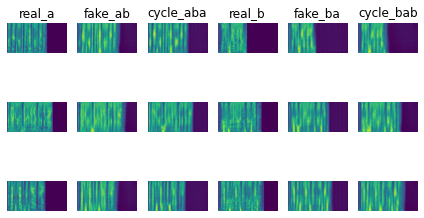

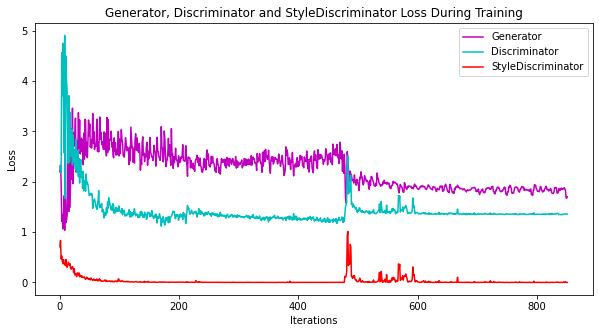

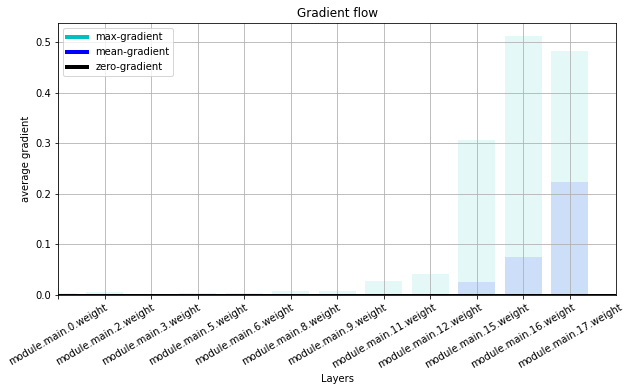

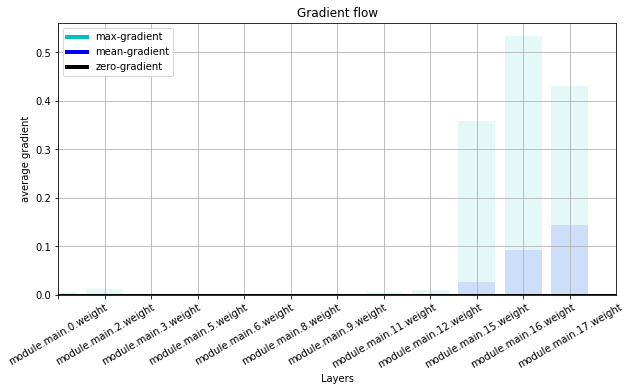

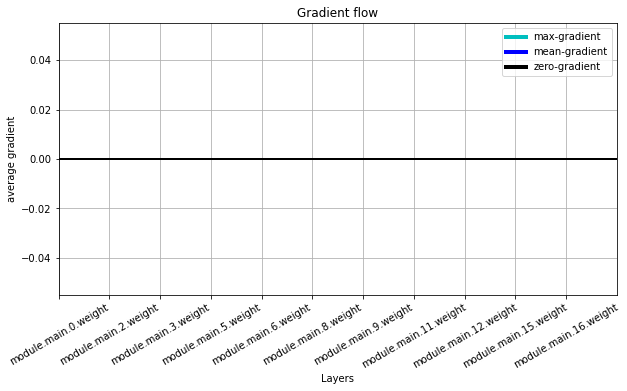

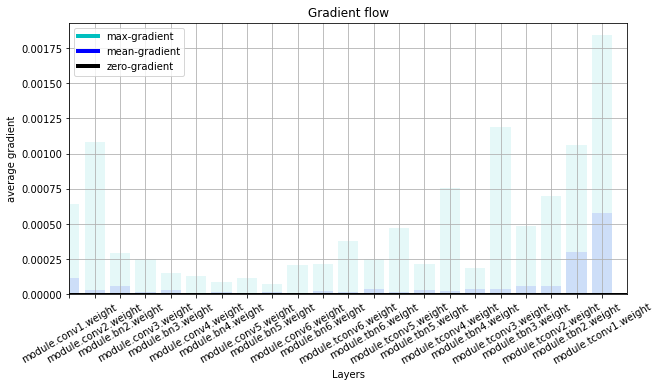

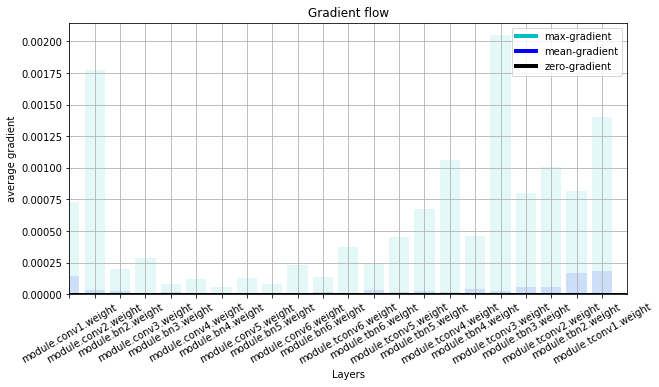

k: 4.0
v: 4.0
gamma: 0.99
---------------------
GEN Loss: 0.79585266 0.81571794
Feature Matching Loss: 2.069734 2.4058793
RECON Loss: 4.0129805 3.5145802
DIS Loss: 0.6873441 0.68261164
Style Loss: 0.00077097694
Delta Loss: 0.0023148728 0.0020679673
Time 9.03140139579773


---------------------
GEN Loss: 0.87556136 0.8781053
Feature Matching Loss: 2.3277183 2.126259
RECON Loss: 4.1833563 3.5489979
DIS Loss: 0.68291664 0.6796009
Style Loss: 0.0015217373
Delta Loss: 0.0023589323 0.0020684358
Time 4.630493879318237


---------------------
GEN Loss: 0.89206254 0.91536283
Feature Matching Loss: 1.4530172 2.1779165
RECON Loss: 4.8124104 3.5183887
DIS Loss: 0.68624055 0.67815673
Style Loss: 0.004275919
Delta Loss: 0.002311753 0.0021425388
Time 2.8817358016967773


---------------------
GEN Loss: 0.8881777 0.93324274
Feature Matching Loss: 2.1206632 2.3703985
RECON Loss: 4.3229876 3.5421185
DIS Loss: 0.6776966 0.67314637
Style Loss: 0.0007590758
Delta Loss: 0.0025937522 0.0019236872
Time 4.137405872344971


---------------------
GEN Loss: 0.9108648 0.9360881
Feature Matching Loss: 1.6398988 2.16644
RECON Loss: 3.989029 3.250688
DIS Loss: 0.67787355 0.6758711
Style Loss: 0.0004980706
Delta Loss: 0.0023324788 0.0019503155
Time 3.7715468406677246


---------------------
GEN Loss: 0.9094503 0.9310158
Feature Matching Loss: 1.5633572 1.9851931
RECON Loss: 3.9224257 3.3664887
DIS Loss: 0.67632806 0.67648745
Style Loss: 0.0011380457
Delta Loss: 0.002477143 0.00218296
Time 2.9231629371643066


---------------------
GEN Loss: 0.9122188 0.91316295
Feature Matching Loss: 1.7695125 1.6656024
RECON Loss: 3.8041553 3.8277104
DIS Loss: 0.6763953 0.67398846
Style Loss: 0.00092219154
Delta Loss: 0.0022769403 0.0019227319
Time 4.167335510253906


---------------------
GEN Loss: 0.9162931 0.87039596
Feature Matching Loss: 2.5801673 2.0452313
RECON Loss: 3.7061017 3.1746898
DIS Loss: 0.675941 0.6689138
Style Loss: 0.0007335343
Delta Loss: 0.0022566044 0.0016470095
Time 2.8089540004730225


---------------------
GEN Loss: 0.91212475 0.8520726
Feature Matching Loss: 1.9234843 2.0668087
RECON Loss: 3.7293115 3.273477
DIS Loss: 0.6760788 0.6767574
Style Loss: 0.00031910153
Delta Loss: 0.0022042997 0.0023222244
Time 3.7210822105407715


---------------------
GEN Loss: 0.9228165 0.84729856
Feature Matching Loss: 1.734806 1.9717014
RECON Loss: 4.0990033 3.3416734
DIS Loss: 0.67538536 0.6792799
Style Loss: 0.00024703122
Delta Loss: 0.0023330394 0.0022930522
Time 3.5059008598327637


---------------------
GEN Loss: 0.9276543 0.8402088
Feature Matching Loss: 2.0380044 1.4898524
RECON Loss: 4.008455 4.307374
DIS Loss: 0.6751464 0.6769879
Style Loss: 0.0005210105
Delta Loss: 0.002323307 0.002366051
Time 3.191037178039551


---------------------
GEN Loss: 0.90025985 0.88407254
Feature Matching Loss: 2.1620994 2.3545222
RECON Loss: 3.961804 3.2981796
DIS Loss: 0.67749196 0.67659914
Style Loss: 0.0041456027
Delta Loss: 0.0022384562 0.002061903
Time 3.9420008659362793


k: 4.0
v: 4.0
gamma: 0.99
---------------------
GEN Loss: 0.9113165 0.8720832
Feature Matching Loss: 1.9650776 2.0792375
RECON Loss: 3.9830918 3.470551
DIS Loss: 0.6751306 0.6739945
Style Loss: 0.0006132979
Delta Loss: 0.0021377217 0.0020692504
Time 1.6486852169036865


---------------------
GEN Loss: 0.9093057 0.8948797
Feature Matching Loss: 2.1846302 1.6247356
RECON Loss: 4.073306 3.8679333
DIS Loss: 0.67567575 0.67528975
Style Loss: 0.0011097675
Delta Loss: 0.0023558522 0.002164991
Time 4.483381748199463


---------------------
GEN Loss: 0.90933806 0.90288365
Feature Matching Loss: 1.9704282 1.9223083
RECON Loss: 4.5822477 3.476658
DIS Loss: 0.6877748 0.6809354
Style Loss: 0.00022176153
Delta Loss: 0.0025414308 0.00215074
Time 3.568267583847046


---------------------
GEN Loss: 0.8959638 0.9259658
Feature Matching Loss: 2.0362544 2.2184572
RECON Loss: 3.8951836 3.4326525
DIS Loss: 0.6792791 0.6756915
Style Loss: 0.0005881171
Delta Loss: 0.0024670027 0.0020274282
Time 3.257340431213379


---------------------
GEN Loss: 0.91200674 0.9306184
Feature Matching Loss: 1.7734574 2.1086333
RECON Loss: 4.3545136 3.8724165
DIS Loss: 0.68228626 0.67407703
Style Loss: 0.008142814
Delta Loss: 0.0025273734 0.0022484716
Time 3.9137628078460693


---------------------
GEN Loss: 0.9053851 0.94183326
Feature Matching Loss: 2.2041593 1.9026777
RECON Loss: 4.213998 3.4366846
DIS Loss: 0.6776256 0.6771319
Style Loss: 0.00031888214
Delta Loss: 0.0024451488 0.002021776
Time 2.9093546867370605


---------------------
GEN Loss: 0.91274077 0.9361676
Feature Matching Loss: 2.43721 2.0224993
RECON Loss: 4.79142 3.8191435
DIS Loss: 0.6779139 0.6738778
Style Loss: 0.0010834439
Delta Loss: 0.0025275482 0.0020084307
Time 4.22265625


---------------------
GEN Loss: 0.90931123 0.94651985
Feature Matching Loss: 2.138277 1.9061561
RECON Loss: 3.8804555 3.4164953
DIS Loss: 0.6759194 0.6733672
Style Loss: 0.00040876854
Delta Loss: 0.002506478 0.001978383
Time 2.9929490089416504


---------------------
GEN Loss: 0.922566 0.9430811
Feature Matching Loss: 1.6769992 1.9375569
RECON Loss: 3.9180815 3.5431995
DIS Loss: 0.67564964 0.67639095
Style Loss: 0.0020437948
Delta Loss: 0.0024921948 0.0020342069
Time 3.82938551902771


---------------------
GEN Loss: 0.9000482 0.93109274
Feature Matching Loss: 1.781035 1.945164
RECON Loss: 5.285871 4.62401
DIS Loss: 0.67246336 0.6766924
Style Loss: 0.004732437
Delta Loss: 0.0021084188 0.0022179687
Time 3.540900230407715


---------------------
GEN Loss: 0.8846904 0.9306457
Feature Matching Loss: 1.7448146 1.7284861
RECON Loss: 4.0566354 3.6079931
DIS Loss: 0.6813247 0.6768814
Style Loss: 0.0008331986
Delta Loss: 0.0022597495 0.0020979224
Time 3.009758949279785


---------------------
GEN Loss: 0.87949646 0.91748095
Feature Matching Loss: 1.7969438 2.2348342
RECON Loss: 4.4629297 3.245778
DIS Loss: 0.674833 0.67846835
Style Loss: 0.0001726239
Delta Loss: 0.002340007 0.0022777948
Time 4.291266679763794


k: 4.0
v: 4.0
gamma: 0.99
---------------------
GEN Loss: 0.88114434 0.92047673
Feature Matching Loss: 1.6966 1.8396049
RECON Loss: 3.8606486 3.143527
DIS Loss: 0.67690265 0.67757785
Style Loss: 0.0001795713
Delta Loss: 0.0025394505 0.0022941618
Time 1.510303258895874


---------------------
GEN Loss: 0.8868712 0.8971687
Feature Matching Loss: 1.9134243 2.099977
RECON Loss: 3.7299116 3.5111322
DIS Loss: 0.67758435 0.67472833
Style Loss: 0.00028835185
Delta Loss: 0.00242279 0.0021804487
Time 4.598170042037964


---------------------
GEN Loss: 0.90432966 0.89636964
Feature Matching Loss: 1.8496518 1.6872244
RECON Loss: 3.7202563 3.496598
DIS Loss: 0.6755058 0.67526615
Style Loss: 0.0014872045
Delta Loss: 0.0026041507 0.0024251123
Time 3.6128194332122803


---------------------
GEN Loss: 0.9081434 0.90293056
Feature Matching Loss: 2.101583 2.266077
RECON Loss: 3.8889956 2.9861724
DIS Loss: 0.6750411 0.67674387
Style Loss: 0.0003388278
Delta Loss: 0.0025252593 0.0022205007
Time 3.0286946296691895


---------------------
GEN Loss: 0.92361504 0.91276515
Feature Matching Loss: 1.7843804 1.8822557
RECON Loss: 3.8476272 3.376793
DIS Loss: 0.67587066 0.67502296
Style Loss: 0.0009214919
Delta Loss: 0.0024807062 0.002145853
Time 4.496108770370483


---------------------
GEN Loss: 0.92685837 0.9198054
Feature Matching Loss: 2.456695 1.9073546
RECON Loss: 3.3549142 2.9865303
DIS Loss: 0.67747897 0.6719386
Style Loss: 0.0026873914
Delta Loss: 0.0022335276 0.0019028226
Time 2.756946563720703


---------------------
GEN Loss: 0.93077016 0.9267232
Feature Matching Loss: 1.9409575 2.273899
RECON Loss: 3.6719398 3.0917854
DIS Loss: 0.67571175 0.6771838
Style Loss: 0.00044184327
Delta Loss: 0.0023104597 0.0019943323
Time 3.1733763217926025


---------------------
GEN Loss: 0.9344856 0.92887825
Feature Matching Loss: 1.4187043 2.0244327
RECON Loss: 3.5545785 3.0791016
DIS Loss: 0.6753457 0.6751916
Style Loss: 0.00034703937
Delta Loss: 0.0025503263 0.002139091
Time 4.77448582649231


---------------------
GEN Loss: 0.9338857 0.93752766
Feature Matching Loss: 1.950675 2.242805
RECON Loss: 3.6994967 2.999568
DIS Loss: 0.6745434 0.67469114
Style Loss: 0.00035806565
Delta Loss: 0.0025132415 0.0020735196
Time 4.358974456787109


---------------------
GEN Loss: 0.9412792 0.9239904
Feature Matching Loss: 1.6538725 1.8012555
RECON Loss: 3.8187637 3.038474
DIS Loss: 0.67554486 0.67658764
Style Loss: 0.0021356263
Delta Loss: 0.0024256795 0.002104835
Time 4.444794416427612


---------------------
GEN Loss: 0.9429981 0.9366449
Feature Matching Loss: 2.4168906 2.09899
RECON Loss: 3.1383386 3.2117245
DIS Loss: 0.6740309 0.67317104
Style Loss: 0.0005619748
Delta Loss: 0.0023806838 0.0021531475
Time 4.325251817703247


---------------------
GEN Loss: 0.9120879 0.928566
Feature Matching Loss: 2.1607862 1.3079183
RECON Loss: 10.368528 8.576631
DIS Loss: 0.6837006 0.67261577
Style Loss: 0.0012410271
Delta Loss: 0.0019787136 0.0020083848
Time 4.442865610122681


k: 4.0
v: 4.0
gamma: 0.99
---------------------
GEN Loss: 0.933943 0.9327307
Feature Matching Loss: 1.6498797 2.1904588
RECON Loss: 6.2738876 3.8340638
DIS Loss: 0.6778441 0.67509156
Style Loss: 0.0005216319
Delta Loss: 0.0018359344 0.0015347206
Time 1.7941007614135742


---------------------
GEN Loss: 0.8787091 0.9167963
Feature Matching Loss: 2.6541767 1.6677656
RECON Loss: 3.4191756 4.106688
DIS Loss: 0.6788322 0.67415786
Style Loss: 0.000890419
Delta Loss: 0.002156389 0.0019524404
Time 5.721698522567749


In [ ]:
epoch_size = 1000

topk = batch_size
gamma = 0.99
v = topk*0.5

# Strong GAN loss for certain period at the beginning
gan_curriculum = 1000
# Set the lambda weight between GAN loss and Recon loss during curriculum period at the beginning. We used the 0.01 weight
starting_rate = 0.01
# Set the lambda weight between GAN loss and Recon loss after curriculum period. We used the 0.5 weight
default_rate = 0.5
# choose among gan/recongan/discogan/spec_gan. gan - standard GAN, recongan - GAN with reconstruction, discogan - DiscoGAN, spec_gan - My modified GAN model for speech
model_arch = "spec_gan"
# Print loss values every log_interval iterations. The current code ensures that the logs are updated 10 times every epoch
log_interval = int(n_batches/10)
# Save test results every image_save_interval iterations
image_save_interval = 2000
# Save models every model_save_interval iterations
model_save_interval = 10000
# Set the path for trained models
task_name = "impersonation"

update_interval = 10

results_folder_name = "CMU_Adam_lr"+str(learning_rate)+"_lr_decay"+str(lr_decay)+"_starting_rate"+str(starting_rate)+"_default_rate"+str(default_rate)

path = "./results/"+results_folder_name
isExist = os.path.exists(path)

if not isExist:
    os.makedirs(path)
    os.makedirs(path+"/images")
    os.makedirs(path+"/gradients")
    os.makedirs(path+"/models")
    print("The new directories are created!")

model_path = path+"/models/"
images_path = path+"/images/"
gradients_path = path+"/gradients/"
    
model_path = os.path.join( model_path, task_name )
model_path = os.path.join( model_path, model_arch )

Path(model_path).mkdir(parents=True, exist_ok=True)

log_gen_loss = np.array([])
log_dis_loss = np.array([])
log_stl_loss = np.array([])
log_delta_A = np.array([])
log_delta_B = np.array([])
log_fm_loss_A = np.array([])
log_fm_loss_B = np.array([])
log_recon_loss_A = np.array([])
log_recon_loss_B = np.array([])
log_gen_loss_A = np.array([])
log_gen_loss_B = np.array([])
img_list = []

plt.figure(figsize=(10, 15))

for epoch in range(epoch_size):
    print("k:", topk)
    print("v:", v)
    print("gamma:", gamma)
    topk = max(gamma*topk,v)
    
    epoch_stats = defaultdict(lambda: 0)
    widgets = ['epoch #%d|' % epoch, Percentage(), Bar(), ETA()]
    pbar = ProgressBar(maxval=n_batches, widgets=widgets)
    pbar.start()
        
    for iters, (A,B) in enumerate(zip(data_A,data_B)):
        
        pbar.update(iters)

        generator_A.zero_grad()
        generator_B.zero_grad()
        discriminator_A.zero_grad()
        discriminator_B.zero_grad()
        discriminator_S.zero_grad()
           
        A = Variable( torch.FloatTensor( A ) ).to(device)
        B = Variable( torch.FloatTensor( B ) ).to(device)
    
        # A -> AB -> ABA
        # A = A.unsqueeze(1)
        AB, AL_feats, LAB_feats = generator_B(A)
        ABA, ABL_feats, ABLA_feats = generator_A(AB)
        # B -> BA -> BAB
        # B = B.unsqueeze(1)
        BA, BL_feats, LBA_feats = generator_A(B)
        BAB, BAL_feats, BALB_feats = generator_B(BA)
        
        recon_loss_BA = recon_criterion( BA, B)
        recon_loss_AB = recon_criterion( AB, A)
        recon_loss_ABA = recon_criterion( ABA, A)
        recon_loss_BAB = recon_criterion( BAB, B)
        
        recon_loss_A = 30 *recon_loss_AB + 70 * recon_loss_ABA
        recon_loss_B = 30 *recon_loss_BA + 70 * recon_loss_BAB 
        
        # Real/Fake GAN Loss (A)
        A_dis = discriminator_A( A )
        BA_dis = discriminator_A( BA )
        ABA_dis = discriminator_A( ABA )
            
        # New part based on Top-k Training of GANs: Improving GAN Performance by Throwing Away Bad Samples
        A_dis = torch.topk(A_dis , int(topk), dim=0)[0]
        BA_dis = torch.topk(BA_dis , int(topk), dim=0)[0]
        ABA_dis = torch.topk(ABA_dis , int(topk), dim=0)[0]
        
        # will be strange in one epoch
        dis_loss_A, gen_loss_A = get_gan_loss( A_dis, BA_dis, ABA_dis, gen_criterion, dis_criterion, topk, device)
                
        fm_loss_A1 = get_fm_loss(AL_feats, ABLA_feats, feat_criterion, device)
        fm_loss_A2 = get_fm_loss(LAB_feats, ABL_feats, feat_criterion, device)
        fm_loss_A = fm_loss_A1 + fm_loss_A2
        
        # Real/Fake GAN Loss (B)
        B_dis = discriminator_B( B )
        AB_dis = discriminator_B( AB )
        BAB_dis = discriminator_B( BAB )
        
        # New part based on Top-k Training of GANs: Improving GAN Performance by Throwing Away Bad Samples
        B_dis = torch.topk(B_dis , int(topk), dim=0)[0]
        AB_dis = torch.topk(AB_dis , int(topk), dim=0)[0]
        BAB_dis = torch.topk(BAB_dis , int(topk), dim=0)[0]

        dis_loss_B, gen_loss_B = get_gan_loss( B_dis, AB_dis, BAB_dis, gen_criterion, dis_criterion, topk, device)
        fm_loss_B1 = get_fm_loss( BL_feats, BALB_feats, feat_criterion, device)
        fm_loss_B2 = get_fm_loss( LBA_feats, BAL_feats, feat_criterion, device)
        fm_loss_B = fm_loss_B1 + fm_loss_B2
        
        # Style Discriminator Loss
        A_stl = discriminator_S(A)
        B_stl = discriminator_S(B)
        AB_stl = discriminator_S(AB) 
        BA_stl = discriminator_S(BA)
        ABA_stl = discriminator_S(ABA) 		
        BAB_stl = discriminator_S(BAB)
        
        stl_loss = get_stl_loss(A_stl, BA_stl, ABA_stl, B_stl, AB_stl, BAB_stl, stl_criterion, device)

        # Delta regularizer
        BA_delta = delta_regu(BA, batch_size)
        AB_delta = delta_regu(AB, batch_size)
        ABA_delta = delta_regu(ABA, batch_size)
        BAB_delta = delta_regu(BAB, batch_size)

        delta_A = BA_delta + ABA_delta
        delta_B = AB_delta + BAB_delta
        
        # Total Loss
        if iters < gan_curriculum:
            rate = starting_rate
        else:
            rate = default_rate
            
        gen_loss_A_total = (gen_loss_A) * (1.-rate) + (recon_loss_A*0.6 + fm_loss_A*0.3 + delta_A*0.1)*rate
        gen_loss_B_total = (gen_loss_B) * (1.-rate) + (recon_loss_B*0.6 + fm_loss_B*0.3 + delta_B*0.1)*rate
        
        if model_arch == 'discogan':
            gen_loss = gen_loss_A_total + gen_loss_B_total
            dis_loss = dis_loss_A + dis_loss_B
        elif model_arch == 'spec_gan':
            gen_loss = gen_loss_A_total + gen_loss_B_total
            dis_loss = dis_loss_A + dis_loss_B + stl_loss
        elif model_arch == 'recongan':
            gen_loss = gen_loss_A_total
            dis_loss = dis_loss_B
        elif model_arch == 'gan':
            gen_loss = (gen_loss_B*0.1 + fm_loss_B*0.9)
            dis_loss = dis_loss_B
            
        if iters % update_interval == 0:
            dis_loss.backward()
            optim_dis.step()
            optim_stl.step()
            
            # LR decay
            if lr_decay == 1:
                sched_dis.step()
                sched_stl.step()
                
        else:
            gen_loss.backward()
            optim_gen.step()
            
            # LR decay
            if lr_decay == 1:
                sched_gen.step()
            
        # if iters % 50 == 0: # Update every 50 batches
        if iters % log_interval == 0:
            print("---------------------")
            print("GEN Loss:", as_np(gen_loss_A.mean()), as_np(gen_loss_B.mean()))
            print("Feature Matching Loss:", as_np(fm_loss_A.mean()), as_np(fm_loss_B.mean()))
            print("RECON Loss:", as_np(recon_loss_A.mean()), as_np(recon_loss_B.mean()))
            print("DIS Loss:", as_np(dis_loss_A.mean()), as_np(dis_loss_B.mean()))
            print("Style Loss:", as_np(stl_loss.mean()))
            print("Delta Loss:", as_np(delta_A.mean()), as_np(delta_B.mean()))
            print("Time", (time.time()-start))
            start = time.time()     
                        
            log_gen_loss = np.hstack([log_gen_loss, as_np(gen_loss.mean())])
            log_dis_loss = np.hstack([log_dis_loss, as_np(dis_loss.mean())])
            log_stl_loss = np.hstack([log_stl_loss, as_np(stl_loss.mean())])
            log_delta_A = np.hstack([log_delta_A, as_np(delta_A.mean())])
            log_delta_B = np.hstack([log_delta_B, as_np(delta_B.mean())])
            log_fm_loss_A = np.hstack([log_fm_loss_A, as_np(fm_loss_A.mean())])
            log_recon_loss_A = np.hstack([log_recon_loss_A, as_np(recon_loss_A.mean())])
            log_fm_loss_B = np.hstack([log_fm_loss_B, as_np(fm_loss_B.mean())])
            log_recon_loss_B = np.hstack([log_recon_loss_B, as_np(recon_loss_B.mean())])
            log_gen_loss_A = np.hstack([log_gen_loss_A, as_np(gen_loss_A.mean())])
            log_gen_loss_B = np.hstack([log_gen_loss_B, as_np(gen_loss_B.mean())])
            
            epoch_stats['log_gen_loss'] = log_gen_loss
                
        if iters % model_save_interval == 0:
            torch.save( generator_A, os.path.join(model_path, 'model_gen_A-' + str( iters / model_save_interval )))
            torch.save( generator_B, os.path.join(model_path, 'model_gen_B-' + str( iters / model_save_interval )))
            torch.save( discriminator_A, os.path.join(model_path, 'model_dis_A-' + str( iters / model_save_interval )))
            torch.save( discriminator_B, os.path.join(model_path, 'model_dis_B-' + str( iters / model_save_interval )))
                    
        if epoch % 5 == 0 and iters % log_interval == 0:
            print('Epoch: '+str(epoch))
            for key, val in epoch_stats.items():
                print(' %s=%6.4f' % (key, val[-1] / iters), end='')

            images_for_plot = {
                'real_a': A, 'fake_ab': AB, 'cycle_aba': ABA,
                'real_b': B, 'fake_ba': BA, 'cycle_bab': BAB,
            }

            for z in range(3):
                for i, (im_title, im) in enumerate(images_for_plot.items()):
                    plt.subplot(3, 6, z * 6 + i + 1)
                    plt.imshow(im[z].detach().cpu().numpy().transpose(1, 2, 0) / 2 + 0.5)
                    if z == 0:
                        plt.title(im_title)
                    plt.axis('off')
                    
            plt.tight_layout()
            display(plt.gcf())
            clear_output(wait=True)
            plt.savefig( os.path.join(images_path, 'model-' + str( epoch ) + ".jpg"))
            
            plt.figure(figsize=(10,5))
            plt.title("Generator, Discriminator and StyleDiscriminator Loss During Training")
            plt.plot(log_gen_loss,label="Generator", color="m")
            plt.plot(log_dis_loss,label="Discriminator", color="c")
            plt.plot(log_stl_loss,label="StyleDiscriminator", color="r")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.legend()
            plt.savefig( os.path.join(path, 'model-' + str( epoch ) + ".jpg"))
            plt.show()
            
            plot_grad_flow(discriminator_A.named_parameters(), 'discriminator_A-' + str( epoch ), gradients_path)
            plot_grad_flow(discriminator_B.named_parameters(), 'discriminator_B-' + str( epoch ), gradients_path)
            plot_grad_flow(discriminator_S.named_parameters(), 'discriminator_S-' + str( epoch ), gradients_path)
            plot_grad_flow(generator_A.named_parameters(), 'generator_A-' + str( epoch ), gradients_path)
            plot_grad_flow(generator_B.named_parameters(), 'generator_B-' + str( epoch ), gradients_path)
    
        plt.close()
        # iters += 1
        
# sio.savemat(result_path +'/log_gen_loss.mat', {'log_gen_loss':log_gen_loss})
# sio.savemat(result_path +'/log_dis_loss.mat', {'log_dis_loss':log_dis_loss})
# sio.savemat(result_path +'/log_stl_loss.mat', {'log_stl_loss':log_stl_loss})
# sio.savemat(result_path +'/log_delta_A.mat', {'log_delta_A':log_delta_A})
# sio.savemat(result_path +'/log_delta_B.mat', {'log_delta_B':log_delta_B})
# sio.savemat(result_path +'/log_gen_loss_A.mat', {'log_gen_loss_A':log_gen_loss_A})
# sio.savemat(result_path +'/log_gen_loss_B.mat', {'log_gen_loss_B':log_gen_loss_B})
# sio.savemat(result_path +'/log_fm_loss_A.mat', {'log_fm_loss_A':log_fm_loss_A}) 
# sio.savemat(result_path +'/log_fm_loss_B.mat', {'log_fm_loss_B':log_fm_loss_B})
# sio.savemat(result_path +'/log_recon_loss_A.mat', {'log_recon_loss_A':log_recon_loss_A}) 
# sio.savemat(result_path +'/log_recon_loss_B.mat', {'log_recon_loss_B':log_recon_loss_B})